In [1]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class Solver(ABC):
    """A solver. It may be initialized with some hyperparameters."""

    @abstractmethod
    def get_parameters(self):
        """Returns a dictionary of hyperparameters"""
        pass

    @abstractmethod
    def solve(self, problem, x0, *args, **kwargs):
        """
        A method that solves the given problem for given initial solution.
        It may accept or require additional parameters.
        Returns the solution and may return additional info.
        """
        pass


class Function(ABC):
    """A function. It may be initialized with some parameters."""

    @abstractmethod
    def __call__(self, x, *args, **kwargs):
        """
        A method that returns the value of the function at given point.
        It may accept or require additional parameters.
        """
        pass

    @abstractmethod
    def gradient(self, x, *args, **kwargs):
        """
        A method that returns the gradient of the function at given point.
        It may accept or require additional parameters.
        """
        pass

In [130]:
def random_spin(vector):
    theta = np.random.uniform(0, 2*np.pi)  # Random angle in [0, 2pi]
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta),  np.cos(theta)]])
    return np.dot(rotation_matrix, vector)

# Test the function
vector = np.array([1.0, 0.0])
print(random_spin(vector))

[ 0.86027125 -0.50983662]


In [143]:
class GradientDescentSolver(Solver):
    def __init__(self, step_size=0.1, max_iter=1000, early_stop=None, get_angry=False, calm_down_treshold=None, patience=None, anger_threshold=None, spin_treshold=None):
        self.step_size = step_size
        self.max_iter = max_iter
        self.stop = early_stop

        self.get_angry = get_angry
        if get_angry:
            self.last_improvements = []
            self.patience = patience
            self.calm_down_treshold = calm_down_treshold
            self.saved_potencial_minimums = []
            self.anger_threshold = anger_threshold
            self.spin_treshold = spin_treshold

    def set_step_size(self, new_step_size):
        self.step_size = new_step_size
        print(f"changed step size to {new_step_size}")

    def get_parameters(self):
        return {"step_size": self.step_size, "max_iter": self.max_iter, "early_stop": self.stop, "get_angry": self.get_angry}

    def solve(self, function, x0):
        x = x0
        init_step_size = self.step_size

        gaining_momentum = False

        apply_spin = False

        for i in range(self.max_iter):
            grad = function.gradient(x)

            if self.stop is not None and np.linalg.norm(grad) < self.stop:
                break

            print(f"iter {i}, x = {x}, f(x) = {function(x)}, grad = {grad}, grad_norm = {np.linalg.norm(grad)}, step_size = {self.step_size}, apply_spin = {apply_spin}")

            x_new = x - (self.step_size * grad)

            if self.get_angry:
                make_move = True

                if gaining_momentum:
                    if (np.linalg.norm(np.array(self.step_size * grad))) > self.calm_down_treshold:
                        self.step_size = init_step_size
                        gaining_momentum = False
                        make_move = False
                    else:
                        self.step_size *= 1.1


                if len(self.last_improvements) >= self.patience and max(self.last_improvements) < self.anger_threshold and not gaining_momentum:
                    print(f"saving potencial minimum {x_new}")
                    self.saved_potencial_minimums.append(x_new)
                    gaining_momentum = True
                    self.last_improvements = []

                if len(self.last_improvements) >= self.patience:
                    self.last_improvements.pop(0)

                self.last_improvements.append(abs(function(x) - function(x_new)))
                if make_move:
                    if apply_spin and gaining_momentum:
                        theta = np.random.uniform(0, 2*np.pi)  # Random angle in [0, 2pi]
                        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                                    [np.sin(theta),  np.cos(theta)]])
                        x = np.dot(rotation_matrix, x_new)
                    else:
                        x = x_new

                simmilar_minimums = 0

                if len(self.saved_potencial_minimums) > 4:
                    temp_saved_potencial_minimums = np.array(self.saved_potencial_minimums)
                    for i in range(len(temp_saved_potencial_minimums)):
                        for j in range(i+1, len(temp_saved_potencial_minimums)):
                            if np.allclose(temp_saved_potencial_minimums[i], temp_saved_potencial_minimums[j], atol=self.spin_treshold):
                                simmilar_minimums += 1
                            if simmilar_minimums > 5:
                                apply_spin = True
                                break
                        if apply_spin:
                            break
            else:
                x = x_new
        if self.get_angry:
            print(len(self.saved_potencial_minimums))
            best_val = None
            for minimum in self.saved_potencial_minimums:
                if best_val is None or function(minimum) < best_val:
                    best_val = function(minimum)
                    x = minimum
        return x

In [45]:
class AnyFunction(Function):
    def __init__(self, equation, gradient):
        self.equation = equation
        self.gradient_func = gradient

    def __call__(self, x, *args, **kwargs):
        return self.equation(x)

    def gradient(self, x, *args, **kwargs):
        return self.gradient_func(x)


In [144]:
def function1(x):
    return 2 * x**2 + 3 * x - 1

def gradient1(x):
    return 4 * x + 3

def function2(x):
    return 1 - 0.6 * np.exp(-x[0]**2 - x[1]**2) - 0.4 * np.exp(-(x[0] + 1.75)**2 - (x[1] - 1)**2)

def gradient2(x):
    return np.array(
        [
            1.2 * x[0] * np.exp(-x[0]**2 - x[1]**2) + 0.8 * (x[0] + 1.75) * np.exp(-(x[0] + 1.75)**2 - (x[1] - 1)**2),
            1.2 * x[1] * np.exp(-x[0]**2 - x[1]**2) + 0.8 * (x[1] - 1) * np.exp(-(x[0] + 1.75)**2 - (x[1] - 1)**2)
        ])

# Initialize an AnyFunction object
f = AnyFunction(function1, gradient1)

g = AnyFunction(function2, gradient2)

solver = GradientDescentSolver(step_size=0.1, max_iter=10000, get_angry=False, calm_down_treshold=1, patience=50, anger_threshold=1e-5, spin_treshold=1e-4)

solver.solve(f, 3)

iter 0, x = 3, f(x) = 26, grad = 15, grad_norm = 15.0, step_size = 0.1, apply_spin = False
iter 1, x = 1.5, f(x) = 8.0, grad = 9.0, grad_norm = 9.0, step_size = 0.1, apply_spin = False
iter 2, x = 0.6, f(x) = 1.5199999999999996, grad = 5.4, grad_norm = 5.4, step_size = 0.1, apply_spin = False
iter 3, x = 0.05999999999999994, f(x) = -0.8128000000000002, grad = 3.2399999999999998, grad_norm = 3.2399999999999998, step_size = 0.1, apply_spin = False
iter 4, x = -0.26400000000000007, f(x) = -1.6526080000000003, grad = 1.9439999999999997, grad_norm = 1.9439999999999997, step_size = 0.1, apply_spin = False
iter 5, x = -0.45840000000000003, f(x) = -1.9549388799999998, grad = 1.1663999999999999, grad_norm = 1.1663999999999999, step_size = 0.1, apply_spin = False
iter 6, x = -0.57504, f(x) = -2.0637779968, grad = 0.69984, grad_norm = 0.69984, step_size = 0.1, apply_spin = False
iter 7, x = -0.645024, f(x) = -2.102960078848, grad = 0.41990399999999983, grad_norm = 0.41990399999999983, step_size =

-0.7499999999999999

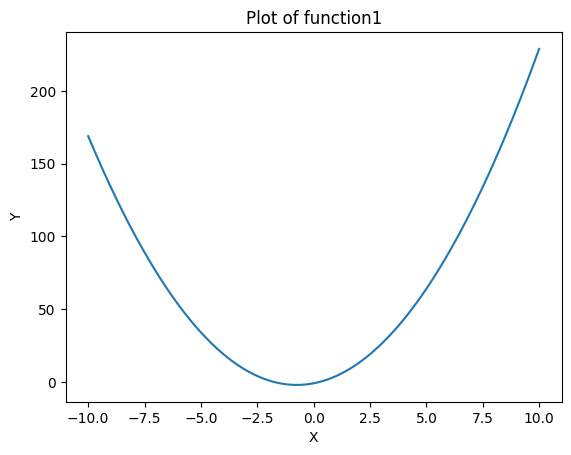

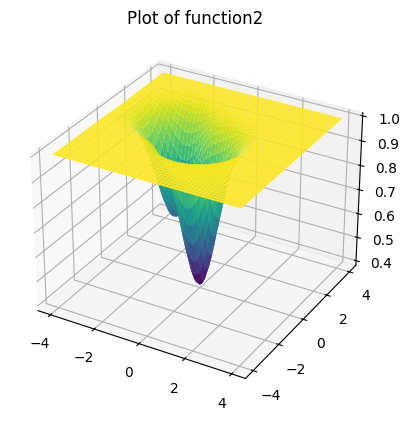

In [6]:
# Generate x values
x = np.linspace(-10, 10, 400)

# Compute y values
y = function1(x)

# Create the plot
plt.plot(x, y)

# Optionally set the title and labels
plt.title('Plot of function1')
plt.xlabel('X')
plt.ylabel('Y')

# Display the plot
plt.show()

size = 4

x = np.linspace(-size, size, 200)
y = np.linspace(-size, size, 200)

X, Y = np.meshgrid(x, y)
Z = function2([X, Y])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.title('Plot of function2')

plt.show()

In [7]:
random_points_f = np.random.uniform(-10, 10, size=(100, 1))
random_points_g = np.random.uniform(-size, size, size=(100, 2))


# for point in random_points_g:
#     print(point, g(point))

# min_x_found = [100, 100]
# for point in random_points_g:
#     x, vals = solver.solve(g, point)
#     if g(x) < g(min_x_found):
#         min_x_found = x

# print(min_x_found)


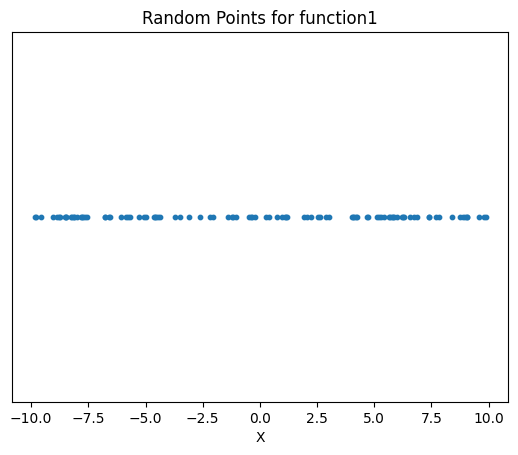

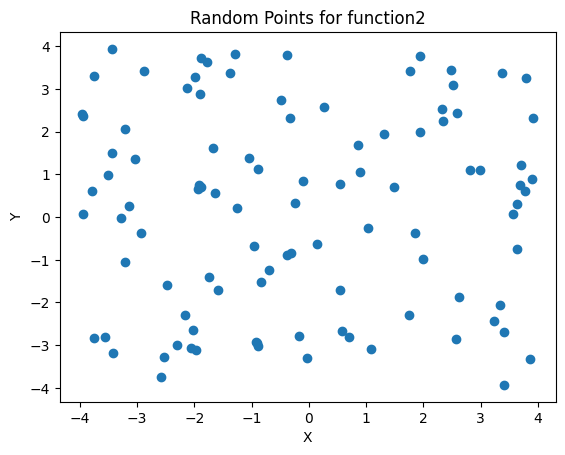

In [8]:
# Create a scatter plot of the points with smaller dots
plt.scatter(random_points_f, np.zeros_like(random_points_f), s=10)

# Hide the y-axis
plt.gca().axes.get_yaxis().set_visible(False)


# Optionally set the title and labels
plt.title('Random Points for function1')
plt.xlabel('X')

# Display the plot
plt.show()



# Split the array into x and y coordinates
x_coords, y_coords = random_points_g[:, 0], random_points_g[:, 1]

# Create a scatter plot of the points
plt.scatter(x_coords, y_coords)

# Optionally set the title and labels
plt.title('Random Points for function2')
plt.xlabel('X')
plt.ylabel('Y')

# Display the plot
plt.show()



changed step size to 0.021970867488504568
changed step size to 0.02979518155208063
changed step size to 0.051048136656095415
changed step size to 0.05740475141487457
changed step size to 0.05489393348973635
changed step size to 0.053244879383581474
changed step size to 0.08028305906287853
changed step size to 0.053646183982944844
changed step size to 0.04688996104722557
changed step size to 0.08936746079941495
changed step size to 0.008797521493538152
changed step size to 0.04490181574226473
changed step size to 0.0882792239890828
changed step size to 0.01556098638756586
changed step size to 0.0770309531971119
changed step size to 0.09205033795275447
changed step size to 0.09287898724729404
changed step size to 0.06449095702802556
changed step size to 0.02694641515676467
changed step size to 0.06941887048423502
changed step size to 0.01967870464043646
changed step size to 0.06227979109648503
changed step size to 0.03506762836405537
changed step size to 0.025836052740823314
changed step

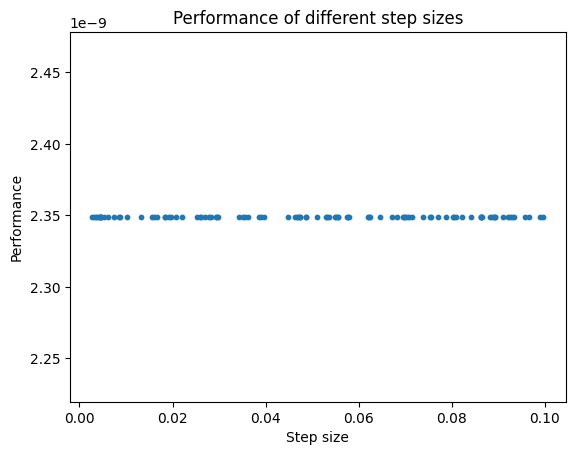

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 100 random step sizes between 0.01 and 1
step_sizes = np.random.uniform(0.001, 0.1, 100)

X = []
Y = []

comparision = []

goal = [-0.0219421, 0.01254356]

for step_size in step_sizes:
    per_step_size_performance = []
    solver.set_step_size(step_size)
    for point in random_points_g:
        x, vals = solver.solve(g, point)

        difference = abs(g(x) - g(goal))
        mqe = difference*100

        per_step_size_performance.append(mqe)
    per_step_size_performance = np.array(per_step_size_performance)
    X.append(step_size)
    Y.append(per_step_size_performance.min())
    comparision.append(per_step_size_performance.mean())

X = np.array(X)
Y = np.array(Y)
comparision = np.array(comparision)

print('best step size:', X[np.argmin(comparision)])

plt.scatter(X, Y, s=10)
plt.title('Performance of different step sizes')
plt.xlabel('Step size')
plt.ylabel('Performance')

plt.show()



In [10]:




# f_xmin, f_vals = solver.solve(f, 0)
g_xmin, g_vals = solver.solve(g, [-5, 5])

print("found minimum for f at x = ", f_xmin)

print("found minimum for g at x = ", g_xmin)

print(f(f_xmin))
print(g(g_xmin))

NameError: name 'f_xmin' is not defined